# Map Salesforce Leads by Campaign
This example script gives a full workflow for producing an interactive, visually appealing geographical map of Salesforce Leads, based on their UK postcodes. The script gives a complete runthrough from start to finish of how to:
* Query the Salesforce API for the Leads associated to a particular Campaign;
* Cleanse the data and identify the geographical latitude and longitude for each Lead based on its UK postcode;
* Use the *Folium* Python package to create an interactive map visualisation of the Leads, which can be viewed inline in a Jupyter notebook, or saved as an HTML file.

To begin we load the required Python packages, and enter the Salesforce credentials to create a connection with the Salesforce API:

In [1]:
# Dependencies
import pandas as pd # For munging data
import folium # For creating interactive maps
import json # Just to load the Salesforce credentials
from simple_salesforce import Salesforce # For managing API requests to Salesforce.

# My credentials are being loaded from a locally stored json file.
credentials = json.load(open("../../credentials/SF_credentials.json"))

# Enter the relevant credentials for your Salesforce org.
sf = Salesforce(password = credentials["password"], \
                username = credentials["username"], \
                organizationId = credentials["organizationId"],\
                security_token = credentials["security_token"])

If we want to map Leads associated to a particular Campaign we will need the Salesforce <code>CampaignId</code> for that Campaign. We can actually use the API to retrieve this if we know what the Campaign Name is in Salesforce:

In [2]:
# This assumes the Campaign Name is unique in Salesforce
campaign_name = "July & August 2017 Circus West Village"

query= """
SELECT Id, Name
FROM Campaign
WHERE Name = 
'""" + campaign_name + "\'"

campaign_id =  sf.query_all(query)['records'][0]["Id"]
campaign_id

'701b0000000FwyvAAC'

Now we have the <code>CampaignId</code> we can use it to query for all the Leads who are Campaign Members on the target campaign:

In [3]:
query= """
SELECT Id, CampaignId, LeadId
FROM CampaignMember
WHERE CampaignId = 
'""" + campaign_id + "\'"

# Convert the results to a Pandas dataframe.
cm_df = pd.DataFrame(sf.query_all(query)['records'])
cm_df.drop('attributes', axis=1, inplace=True) # Drop irrelevant columns returned by query
cm_df.head()

,Id,CampaignId,LeadId
0,00vb000000gVmuDAAS,701b0000000FwyvAAC,00Qb000000Unj34EAB
1,00vb000000gVmriAAC,701b0000000FwyvAAC,00Qb000000Unj8sEAB
2,00vb000000gVmpZAAS,701b0000000FwyvAAC,00Qb000000UoAosEAF
3,00vb000000gVmpaAAC,701b0000000FwyvAAC,00Qb000000UoAotEAF
4,00vb000000gVmpbAAC,701b0000000FwyvAAC,00Qb000000UoAouEAF


We want to map the Leads, so we now need to query the Lead object to get the UK postcodes of each lead.

We query the Lead object for all Leads with a specific <code>RecordTypeId</code> who have a postcode recorded, and then merge the returned Leads with the above <code>cm_df</code> dataframe to get our Campaign_Leads dataframe (<code>cm_ld_df</code>).

We'll also include the <code>LeadSource</code> field in the query, which will be used to colour the markers on our final map.

In [4]:
query= """
SELECT Id, PostalCode, LeadSource
FROM Lead
WHERE PostalCode != Null
AND RecordTypeId = '012b0000000DrLy'
"""

# Convert the results to a Pandas dataframe.
leads_df = pd.DataFrame(sf.query_all(query)['records'])
leads_df.drop('attributes',axis=1,inplace=True) # Drop irrelevant columns returned by query
leads_df.head()

,Id,PostalCode,LeadSource
0,00Qb000000UmLtQEAV,SS7 5PH,None
1,00Qb000000UmLwUEAV,CM4ODJ,None
2,00Qb000000UmLx8EAF,SW11 4AN,None
3,00Qb000000UmMAJEA3,CU5 ER5,None
4,00Qb000000UmMCtEAN,SW118NG,None


In [5]:
# Merge the dataframes
cm_ld_df = pd.merge(leads_df, cm_df[['LeadId']], how='inner', left_on='Id',right_on='LeadId')

# Drop duplicate LeadId column
cm_ld_df.drop(labels = ["LeadId"], axis = 1, inplace = True)

# Look at the last few rows to see how many records returned
cm_ld_df.tail()

,Id,PostalCode,LeadSource
778,00Qb000000UoAvNEAV,SW11 8ED,Local knowledge
779,00Qb000000UoAvOEAV,SW11 3BS,Social media
780,00Qb000000UoB76EAF,SW2 5UU,Word of mouth
781,00Qb000000UoB77EAF,SW113H4,Walked / cycled past
782,00Qb000000UoB78EAF,SW8 2SZ,Social media


Now we have the Leads in a dataframe with their postcodes, we need to load the UK postcodes with the corresponding latitudes and longitudes which will be used for mapping.

In [6]:
# Load UK postcodes from a csv file
postcodes_df = pd.read_csv("./ukpostcodes.csv")

# Quick look at the postcodes data
postcodes_df.head()

,postcode,latitude,longitude,postcode_clean
0,AB10 1XG,57.144165,-2.114848,ab101xg
1,AB10 6RN,57.137880,-2.121487,ab106rn
2,AB10 7JB,57.124274,-2.127190,ab107jb
3,AB11 5QN,57.142701,-2.093295,ab115qn
4,AB11 6UL,57.137547,-2.112233,ab116ul


The <code>postcode_clean</code> column contains a standardised format of the postcode in lower case, with spaces removed. We'll add the same column to the Leads dataframe to ensure we do not miss any due to bad formatting of data:

In [7]:
cm_ld_df['postcode_clean'] = [cm_ld_df.loc[row, "PostalCode"].replace(" ","").lower() for row in range(len(cm_ld_df))]
cm_ld_df.head()

,Id,PostalCode,LeadSource,postcode_clean
0,00Qb000000Unj34EAB,SE14 5RD,None,se145rd
1,00Qb000000UoAvQEAV,RH1GDX,Word of mouth,rh1gdx
2,00Qb000000UoAvREAV,E1 5LX,Social media,e15lx
3,00Qb000000UoAw9EAF,SW8 4JY,Advertising,sw84jy
4,00Qb000000UoAwAEAV,SW8 4JY,Advertising,sw84jy


For mapping the <code>LeadSource</code> attributes onto the markers on our map, we'll also replace any recorded as "None" with "Unknown" to be more easily interpretable:

In [8]:
cm_ld_df.fillna(value = "Unknown", inplace = True)
cm_ld_df.head()

,Id,PostalCode,LeadSource,postcode_clean
0,00Qb000000Unj34EAB,SE14 5RD,Unknown,se145rd
1,00Qb000000UoAvQEAV,RH1GDX,Word of mouth,rh1gdx
2,00Qb000000UoAvREAV,E1 5LX,Social media,e15lx
3,00Qb000000UoAw9EAF,SW8 4JY,Advertising,sw84jy
4,00Qb000000UoAwAEAV,SW8 4JY,Advertising,sw84jy


Now we merge the cleaned <code>cm_ld_df</code> with the <code>postcodes_df</code> to get our final dataframe for mapping.

In [9]:
final_df = pd.merge(cm_ld_df, postcodes_df, how = 'inner', left_on = 'postcode_clean', right_on = 'postcode_clean')
final_df.head()

,Id,PostalCode,LeadSource,postcode_clean,postcode,latitude,longitude
0,00Qb000000Unj34EAB,SE14 5RD,Unknown,se145rd,SE14 5RD,51.480013,-0.048773
1,00Qb000000UoAvREAV,E1 5LX,Social media,e15lx,E1 5LX,51.519436,-0.069920
2,00Qb000000UoAw9EAF,SW8 4JY,Advertising,sw84jy,SW8 4JY,51.476806,-0.140858
3,00Qb000000UoAwAEAV,SW8 4JY,Advertising,sw84jy,SW8 4JY,51.476806,-0.140858
4,00Qb000000UoAwBEAV,SW11 4DB,Other,sw114db,SW11 4DB,51.476606,-0.149823


### Now we begin mapping with *folium*

In order to map the <code>LeadSource</code> field using different coloured markers, we need to create the mapping between sources and colours:

In [10]:
# Get the unique values for LeadSource
sources = final_df["LeadSource"].unique()

# Create an array of colours to iterate through
marker_colours = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
         'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
         'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
         'gray', 'black', 'lightgray'] 

# Create the dictionary to map source:colour
colour_dict = {}
colour_index = 0
for source in sources:
    colour_dict[source] = marker_colours[colour_index]
    colour_index += 1
colour_dict

{'Advertising': 'green',
 'Leaflet': 'beige',
 'Local knowledge': 'lightred',
 'Neighbourhood Newsletter': 'darkgreen',
 'Other': 'purple',
 'Press': 'darkpurple',
 'Previous purchaser': 'cadetblue',
 'Social media': 'blue',
 'Unknown': 'red',
 'Walked / cycled past': 'orange',
 'Word of mouth': 'darkred',
 'Work nearby': 'darkblue'}

Now create the map:

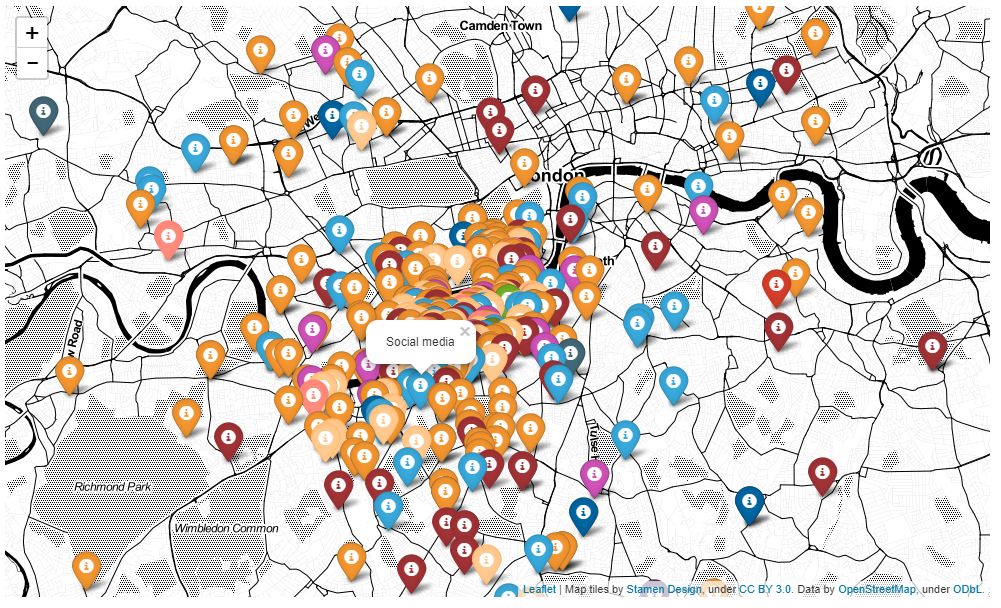

In [11]:
# Start by creating a base map centred on London coordinates
london_start_coordinates = (51.481442, -0.144297)

# Create the map object
my_map = folium.Map(location = london_start_coordinates, zoom_start = 12, tiles = 'Stamen Toner')

# Iterate through the final_df adding markers to the map for each Lead
for row in range(len(final_df)):
    source = final_df.loc[row, "LeadSource"]
    colour = colour_dict[source]
    folium.Marker((final_df.loc[row, "latitude"], final_df.loc[row, "longitude"]),\
                  popup = source,\
                  icon = folium.Icon(color = colour)).add_to(my_map)

# View the map inline by just calling the map:
# my_map
# Note - image displayed here in place of inline map, because
# inline rendering doesn't work on github.
from IPython.display import Image
Image("./images/london_map_example.PNG")

In [12]:
# The map can also be saved to an html file
my_map.save("./my_map.html")